In [1]:
import src.ptmodel as ptm
import src.geotools as gt
import src.densenet as dn
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import torch
import gdal
from skimage.transform import rescale
import rasterio

%load_ext autoreload
%autoreload 2

In [2]:
imds=rasterio.open('data/P12_005773_0849_XN_84S045W_clipped.img')
im=imds.read()[0,:,:]
ddrimds=rasterio.open('data/P12_005773_0849_XN_84S045W_ddr_final.img')
ddrim=ddrimds.read()
dsimds=rasterio.open('data/P12_005773_0849_XN_84S045W_clipped.img')
dsim=dsimds.read()[0,:,:]
print(dsim.shape)
neighbs=2
masterrows,mastercols=np.where(dsim > 0)
im,dsim=np.expand_dims(im,0),np.expand_dims(dsim,0)

(3949, 2456)


(array([4.383942e+06, 4.473400e+04, 1.728000e+03, 6.580000e+02,
        7.586100e+04, 1.435804e+06, 2.372719e+06, 1.047667e+06,
        3.347770e+05, 8.540000e+02]),
 array([ 0. ,  8.1, 16.2, 24.3, 32.4, 40.5, 48.6, 56.7, 64.8, 72.9, 81. ]),
 <a list of 10 Patch objects>)

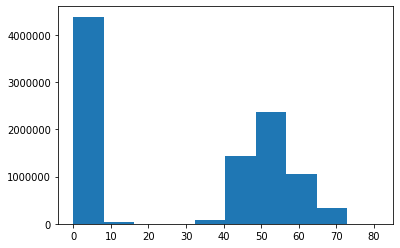

In [4]:
plt.hist(dsim.flatten())

In [10]:
Nsplits=5
splitrows=np.split(masterrows,np.arange(len(masterrows)//Nsplits,len(masterrows),len(masterrows)//Nsplits))
splitcols=np.split(mastercols,np.arange(len(masterrows)//Nsplits,len(masterrows),len(masterrows)//Nsplits))
splittups=list(zip(splitrows,splitcols))
masterpredlist=[]
outrowlist,outcollist=[],[]
print([len(x) for x in splitrows])
for chunktup in splittups:
    goodrows,goodcols=chunktup
    print(str(len(goodrows)) + ' Total Candidate Extracts.')
    ctxsamps,ddrsamps=[],[]
    finalrows,finalcols = [],[]
    for rind,dsrow in enumerate(goodrows):
        dscol=goodcols[rind]
        xy=dsimds.xy(dsrow,dscol)
        
        ctxpt=imds.index(xy[0],xy[1])
        ctxrow,ctxcol=ctxpt[0],ctxpt[1]
        

        ddrrow,ddrcol=ddrimds.index(xy[0],xy[1])
        
        ctxextract= im[:, (ctxrow - neighbs - 1): (ctxrow + neighbs + 2),
                         (ctxcol - neighbs - 1): (ctxcol + neighbs + 2)]
        ddrextract= ddrim[:, (ddrrow - neighbs - 1): (ddrrow + neighbs + 2),
                         (ddrcol - neighbs - 1): (ddrcol + neighbs + 2)]
        if (len(ctxextract.flatten()[ctxextract.flatten() == 0]) == 0) \
           & (len(ddrextract.flatten()[ddrextract.flatten() == 0]) == 0) \
           & ((1,7,7) in [ctxextract.shape]) \
           & ((8,7,7) in [ddrextract.shape]):
            ctxsamps.append(ctxextract)
            ddrsamps.append(ddrextract)
            finalrows.append(dsrow)
            finalcols.append(dscol)
    print(len(ctxsamps),len(ddrsamps))
    
    if len(ctxsamps) == 0:
        continue
    outrowlist.extend(finalrows)
    outcollist.extend(finalcols)
    datadict={'DDR':ddrsamps,'CTX':ctxsamps}
    print(ctxsamps[1].shape)
    predds=ptm.ICEsDataset(datadict)
    predds.normalize(catddr=True)
    pred_loader = torch.utils.data.DataLoader(
            predds, batch_size=1500)






    torch.cuda.empty_cache()
    use_cuda = torch.cuda.is_available()
    torch.manual_seed(1234)
    device = torch.device("cuda" if use_cuda else "cpu")
    inmodel = dn.DenseNet(growth_rate=16, block_config=(1, 2, 2, 3),
                          num_init_features=48, bn_size=1, drop_rate=0,
                          num_classes=1, memory_efficient=False).to(device)
    inmodel.load_state_dict(torch.load('models/Icesv1.pt'))
    
    inmodel.eval()
    with torch.no_grad():   
            for batch_idx, data in enumerate(pred_loader):
                data = data['X'].to(device, dtype=torch.float)
                output = inmodel(data)
                pred=output.cpu().numpy()[:,0]
                masterpredlist.append(pred)
           

[1062960, 1062960, 1062960, 1062960, 1062960, 2]
1062960 Total Candidate Extracts.
1033110 1033110
(1, 7, 7)
(1033110, 9, 7, 7)
1062960 Total Candidate Extracts.
1044579 1044579
(1, 7, 7)
(1044579, 9, 7, 7)
1062960 Total Candidate Extracts.
1044837 1044837
(1, 7, 7)
(1044837, 9, 7, 7)
1062960 Total Candidate Extracts.
1051058 1051058
(1, 7, 7)
(1051058, 9, 7, 7)
1062960 Total Candidate Extracts.
1052920 1052920
(1, 7, 7)
(1052920, 9, 7, 7)
2 Total Candidate Extracts.
0 0


(3949, 2456)


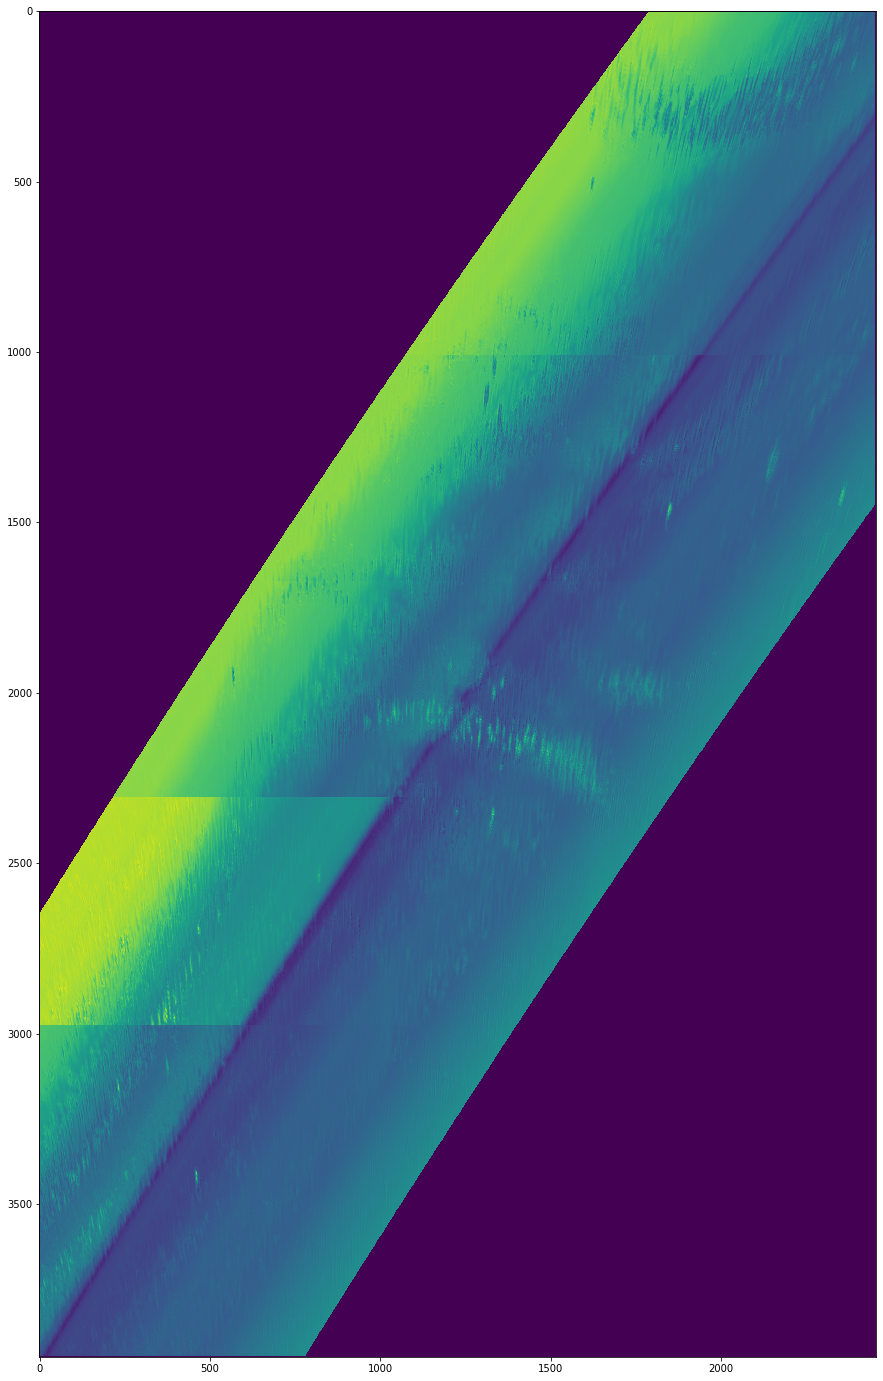

In [11]:
outim=np.zeros(dsim.shape[1:])
print(outim.shape)
predarr=np.concatenate(masterpredlist)
for rind,row in enumerate(outrowlist):
    col=outcollist[rind]
    try:
        outim[row,col]=predarr[rind]
    except IndexError:
        break
plt.figure(figsize=(15,30))
plt.imshow(outim)
plt.show()